LCOE_låg är: 37658414.07369985
LCOE_medel är: 51525537.71975408
LCOE_hög är: 59065708.2911601
Summa kostnad i el 2023: 12810258.282820417
Original elförbrukning topptimmar:                  Timme  Elförbrukning
0  2023-03-23 17:00:00        1693.00
1  2023-03-25 17:00:00        1693.00
2  2023-03-24 17:00:00        1641.00
3  2023-04-07 18:00:00        1627.00
4  2023-04-02 18:00:00        1614.00
5  2023-04-12 18:00:00        1611.00
6  2023-03-26 17:00:00        1602.00
7  2023-04-05 18:00:00        1596.00
8  2023-04-01 18:00:00        1594.00
9  2023-03-31 17:00:00        1593.00
10 2023-03-25 18:00:00        1586.00
11 2023-03-30 17:00:00        1580.00
12 2023-04-03 18:00:00        1576.00
13 2023-03-24 18:00:00        1571.00
14 2023-03-30 18:00:00        1570.00
15 2023-04-06 18:00:00        1567.00
16 2023-04-04 18:00:00        1563.00
17 2023-03-27 17:00:00        1561.00
18 2023-12-04 17:00:00        1555.75
19 2023-03-31 18:00:00        1555.00
20 2023-04-09 18:00:00       

C:\Users\jakob\AppData\Local\Temp\ipykernel_15168\1796468733.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_15168\1796468733.py:53: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_15168\1796468733.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_ABK = ABKEl["ABKEl"].resample("M").sum()
C:\Users\jakob\AppData\Local\Temp\ipykernel_15168\1796468733.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_


Total elkostnad för sänkan (inkl. moms): 3282482.28 kr
Justerad elkostnad simulering: 7431060.295831302
Besparing_låg efter 30 år: 123717525.5359736
Besparing_medel efter 30 år: 109850401.88991937
Besparing_hög efter 30 år: 102310231.31851333


C:\Users\jakob\AppData\Local\Temp\ipykernel_15168\1796468733.py:278: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_15168\1796468733.py:285: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()


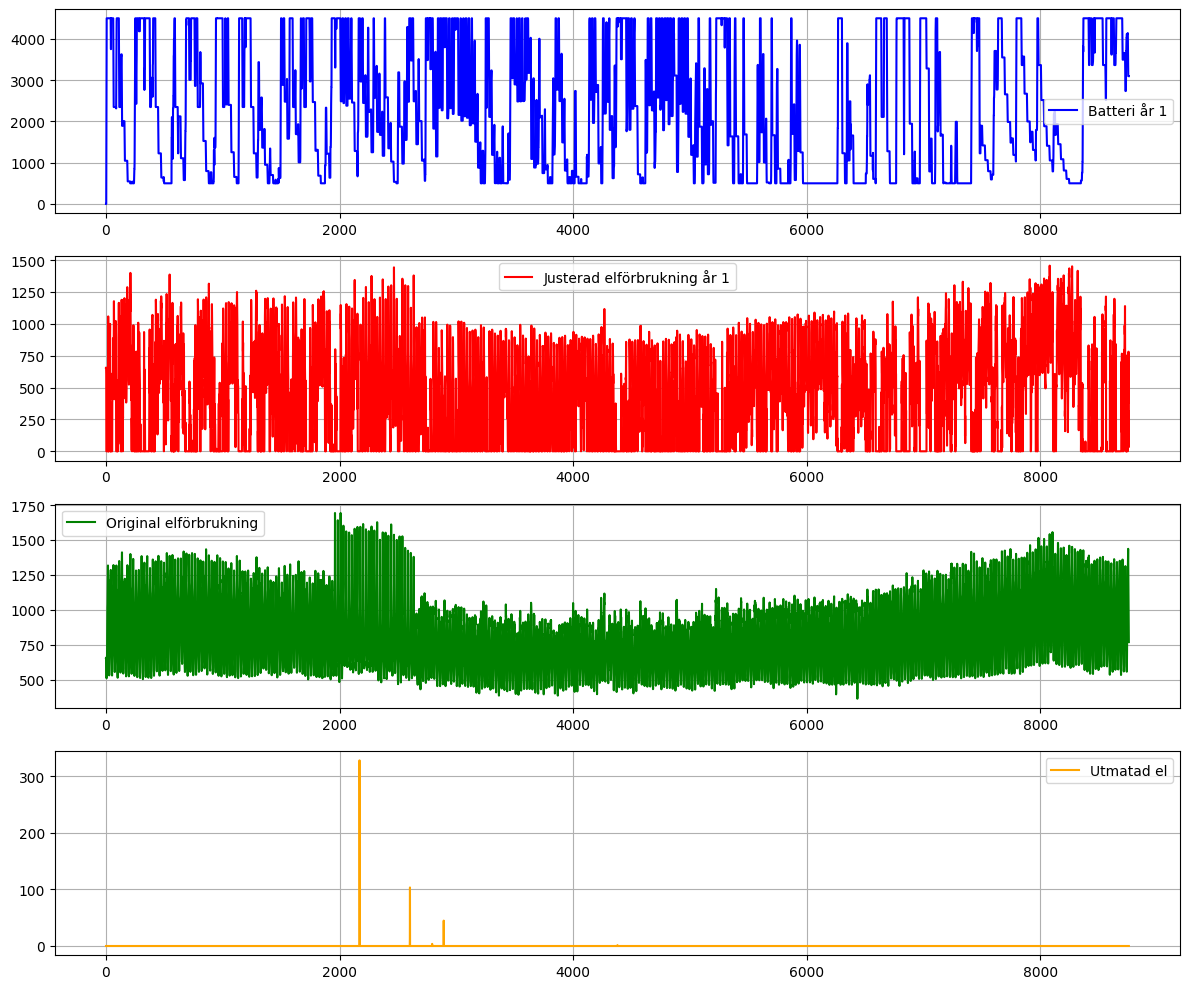

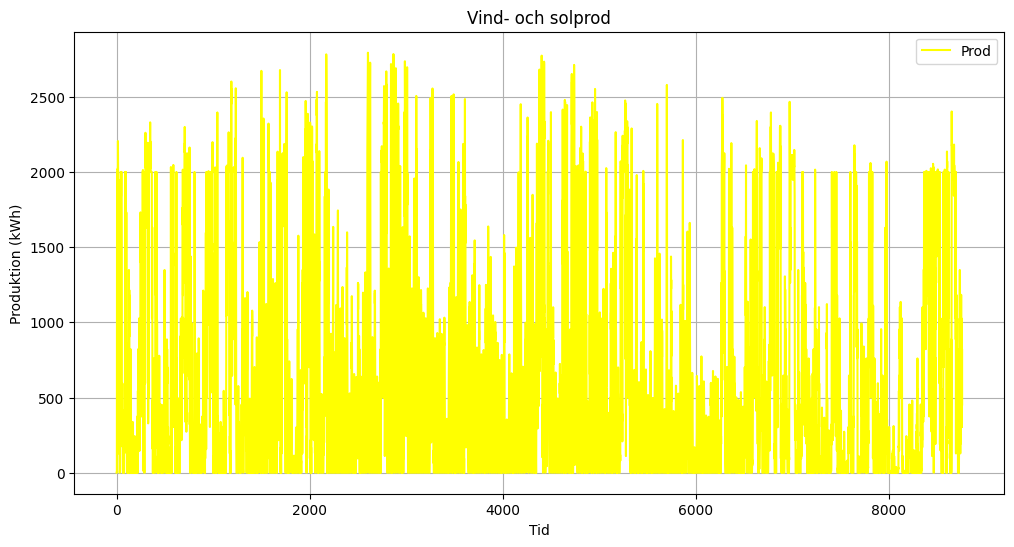

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Läs in Excel-filer
Solprod = pd.read_excel("SolprodABK.xlsx", header=None)
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"], header=None)
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"], header=None)  # Namnge kolumnen korrekt
Vindprod = pd.read_excel("Vindturbin.xlsx", header=None)
StarkaEl = pd.read_excel("Starka2023.xlsx", header=None)
KLTel = pd.read_excel("KLTelFörbr.xlsx", header=None)
Skånemej = pd.read_excel("Eldata-filerSÖDRA/SkånemejElförbr.xlsx", header= None)

Mejan = Skånemej.iloc[:, 0]
# Extrahera första kolumnen från respektive DataFrame
Starka = StarkaEl.iloc[:, 0]
KLT = KLTel.iloc[:, 0]
Sol = 0.17*Solprod.iloc[:, 0]  # SOL = 0.26, Sol+Vind = 0.17
Vind = Vindprod.iloc[:, 0]

Sänka = Starka + KLT + Mejan
Prod =  Sol + Vind

LCOE_sol_låg = 0.29 #kr/kWh
LCOE_sol_medel = 0.43
LCOE_sol_hög = 0.52

LCOE_vind_låg = 0.24
LCOE_vind_medel = 0.32
LCOE_vind_hög = 0.36

livslängd = 30


LCOE_låg = (Sol.sum()*LCOE_sol_låg + Vind.sum()*LCOE_vind_låg)*30
LCOE_medel = (Sol.sum()*LCOE_sol_medel + Vind.sum()*LCOE_vind_medel)*30
LCOE_hög = (Sol.sum()*LCOE_sol_hög+ Vind.sum()*LCOE_vind_hög)*30

print("LCOE_låg är:", LCOE_låg)
print("LCOE_medel är:", LCOE_medel)
print("LCOE_hög är:", LCOE_hög)

Prod_list = Prod.tolist()

# Konvertera Spotpris till en lista för iteration
Spot_list = Spotpris["Spotpris"].tolist()
ABK_list = ABKEl["ABKEl"].tolist()

# Skapa tidsindex för ABKEl och Spotpris
ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
ABKEl.set_index("Tid", inplace=True)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

# Resampla till månatligt total
monthly_total_ABK = ABKEl["ABKEl"].resample("M").sum()

# Beräkna överföringsavgift per månad
Spotpris["E"] = 4.004 + 0.0613 * Spotpris["Spotpris"]
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna summa överföringsavgift för hela året
summaÖverfAvgift = (monthly_avg_E * monthly_total_ABK).sum()
fastAbbKostnad = 795180.4
summaElnätskostnadKR = (summaÖverfAvgift / 100) + fastAbbKostnad

Spot_array = np.array(Spot_list)
ABK_array = np.array(ABK_list)

elhandelskostnad = (Spot_array * ABK_array).sum() / 100
energiskatt = (43.9 * ABK_array).sum() / 100

summaElKostnad = (summaElnätskostnadKR + elhandelskostnad + energiskatt) * 1.25

print("Summa kostnad i el 2023:", summaElKostnad)

# Ta fram elförbrukning (första kolumnen) som en Pandas Series
elförbrukning = pd.Series(ABKEl.iloc[:, 0])

# Sortera elförbrukningen i fallande ordning och hämta de 30 högsta värdena
top_30_hours = elförbrukning.sort_values(ascending=False).head(30)

# Skapa en DataFrame med radnummer (index) och värde (elförbrukning)
top_30_with_index = top_30_hours.reset_index()

# Byt namn på kolumnerna för bättre läsbarhet
top_30_with_index.columns = ['Timme', 'Elförbrukning']

# Skriv ut de 30 timmarna med högst elförbrukning och radnummer
print("Original elförbrukning topptimmar: " + top_30_with_index.to_string())
print("Snitt originaltopptimmar: " + str(top_30_hours.mean()))



# ----------------------- YEAR 1 SIMULATION -----------------------
# Initialize Battery and Costs
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
maxFrånBatteri = 1500
min_battery_level = batteriMaxKapacitet*0.1
max_battery_level = batteriMaxKapacitet * 0.9


# Lists to store values for plotting
justeradElförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
original_consumption = ABKEl["ABKEl"].tolist()
köptaTimmar = []  # Lista för köpta spotpriser och tid
utmatning = []
faktor = 0.1

sänka_tid = []
sänka_konsumtion = []
sänka_spotpris = []


#energiFrånBatteri = min(batteriKapacitet * faktor, diff, maxFrånBatteri, batteriKapacitet - min_battery_level)
#energiFrånBatteri = max(0, energiFrånbatteri)

for i, (tid, prod, abk, spot, sänka) in enumerate(zip(Spotpris.index, Prod, ABK_list, Spot_list, Sänka)):
    diff = abk - prod  # Difference between consumption and solar production


    if i < 2800:
        faktor = 0.15
    elif  2800 <= i <= 7500:
        faktor = 0.3
    else:
        faktor = 0.07

    if diff <= 0:
        batteriKapacitet = min(batteriKapacitet - diff, max_battery_level)
        justeradElförbrukning.append(0)

    # Maxpotential till sänka från överskott (det som inte går till batteri)
        överskott = -diff  # diff är negativ, så -diff är produktion över förbrukning
        möjlig_utmatning = max(0, överskott - (max_battery_level - batteriKapacitet))

        till_sänka = min(sänka, möjlig_utmatning)
        till_nätet = max(0, möjlig_utmatning - till_sänka)

        utmatning.append(till_nätet)
        köptaTimmar.append((tid, 0))

        if till_sänka > 0:
            sänka_tid.append(tid)
            sänka_konsumtion.append(till_sänka)
            sänka_spotpris.append(Spotpris.loc[tid, "Spotpris"])
    else:  
        
        if 15 <= tid.hour < 19 and prod == 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, abk - energiFrånBatteri)
            justeradElförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append(0)
        elif 15 <= tid.hour < 19 and prod > 0:
            energiFrånBatteri = min(batteriKapacitet * faktor, diff,  maxFrånBatteri, max(0, batteriKapacitet - min_battery_level))

            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            justeradElförbrukning.append(köpt_el)
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
            utmatning.append(0)
        elif prod > 0:
            justeradElförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
            utmatning.append(0)
            
        else:
            justeradElförbrukning.append(abk)  
            köptaTimmar.append((tid, spot))
            utmatning.append(0)

    
    battery_values.append(batteriKapacitet)

# ----------------------- BERÄKNA DAGLIG DoD -----------------------

# Skapa DataFrame med tidsindex och batterinivå
battery_df = pd.DataFrame({
    "Tid": Spotpris.index[:len(battery_values)],
    "Batteri": battery_values
})
battery_df.set_index("Tid", inplace=True)

# Räkna ut daglig max och min batterinivå
daily_max = battery_df["Batteri"].resample("D").max()
daily_min = battery_df["Batteri"].resample("D").min()

# Räkna ut DoD per dag i procent
daily_DoD = (daily_max - daily_min) / batteriMaxKapacitet * 100

# Räkna ut genomsnittligt dagligt DoD
average_DoD = daily_DoD.mean()

print(f"\nGenomsnittligt dagligt Depth of Discharge (DoD) under året: {average_DoD:.2f}%")

# Konvertera elförbrukning till en NumPy-array
elförbrukning_array = np.array(justeradElförbrukning)

# Hitta de 30 högsta värdena i elförbrukning
top_30_indices = np.argsort(elförbrukning_array)[-30:]  # Index för de 30 största värdena

# Hämta de faktiska tidsstämplarna från Spotpris.index
top_30_times = Spotpris.index[top_30_indices]

# Hämta de 30 största elförbrukningsvärdena
top_30_values = elförbrukning_array[top_30_indices]

# Sortera topp 30 i fallande ordning och behåll index
sorted_pairs = sorted(zip(top_30_values, top_30_times), reverse=True)
values_only = [value for value, _ in sorted_pairs]
mean_value = sum(values_only) / len(values_only)
print(f"Snitt = {mean_value:.2f}")


# Skriv ut de 30 högsta värdena tillsammans med originaltimmarna
print("De 30 högsta elförbrukningsvärdena och deras timmar i Excel-filen:")

for i, (value, original_time) in enumerate(sorted_pairs):
    excel_rad = i + 8  # +8 för rubrikrad och 1-baserade index, och +1 för att börja från 1
    print(f"{i+1}. Timme {original_time}  - Förbrukning: {value} (Excel rad: {excel_rad})")


# Fyll på elförbrukningen om den är kortare än Spotpris.index
if len(justeradElförbrukning) < len(Spotpris.index):
    justeradElförbrukning.extend([0] * (len(Spotpris.index) - len(justeradElförbrukning)))



sänka_df = pd.DataFrame({
    "Tid": sänka_tid,
    "El": sänka_konsumtion,
    "Spotpris": sänka_spotpris
})
sänka_df.set_index("Tid", inplace=True)

# Elhandelskostnad (kr)
sänka_df["Elhandelskostnad"] = sänka_df["El"] * sänka_df["Spotpris"] / 100
total_elhandelskostnad_sänka = sänka_df["Elhandelskostnad"].sum()

# Överföringsavgift (kr)
sänka_df["E"] = 2.23 + 0.0583 * sänka_df["Spotpris"]
monthly_avg_E_sänka = sänka_df["E"].resample("M").mean()
monthly_total_elförbrukning_sänka = sänka_df["El"].resample("M").sum()
summaJusteradÖverf_sänka = ((monthly_avg_E_sänka * monthly_total_elförbrukning_sänka).sum()) / 100

# Effektkostnad (kr)
monthly_max_effekt = sänka_df["El"].resample("M").max()
effektavgift = 57.04  # kr/kW
total_effektkostnad_sänka = (monthly_max_effekt * effektavgift).sum()

# Energiskatt (kr)
energiskatt_sänka = sänka_df["El"].sum() * 43.9 / 100

# Total elkostnad sänka inkl moms (kr)
summa_sänka = (
    total_elhandelskostnad_sänka +
    summaJusteradÖverf_sänka +
    total_effektkostnad_sänka +
    energiskatt_sänka
)
summa_sänka_med_moms = summa_sänka * 1.25

print(f"\nTotal elkostnad för sänkan (inkl. moms): {summa_sänka_med_moms:.2f} kr")

# Skapa DataFrame med tid som index
köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

köptaTimmar_df["E"] = 4.004 + 0.0613 * köptaTimmar_df["Spotpris"]

# Beräkna månatligt medelvärde för köpta spotpriser
monthly_avg_E_köpt = köptaTimmar_df["E"].resample("M").mean()

# Skapa DataFrame för den uppdaterade elförbrukningen
elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": justeradElförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde av den uppdaterade elförbrukningen
monthly_total_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").sum()

# Beräkna justerad överföringsavgift
summaJusteradÖverf = (monthly_avg_E_köpt * monthly_total_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastAbbKostnad

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(justeradElförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt + summaJusteradÖverfKR)

print("Justerad elkostnad simulering:", summaJusteradElkostnad)

print("Besparing_låg efter 30 år:", (summaElKostnad - summaJusteradElkostnad)*30 - LCOE_låg)
print("Besparing_medel efter 30 år:", (summaElKostnad - summaJusteradElkostnad)*30 - LCOE_medel)
print("Besparing_hög efter 30 år:", (summaElKostnad - summaJusteradElkostnad)*30 - LCOE_hög)

# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(4, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(justeradElförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')
ax[3].plot(utmatning, label='Utmatad el', color='orange')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

# Skapa en figur och plotta
plt.figure(figsize=(12, 6))
plt.plot(Prod_list, label="Prod", color="yellow")

plt.xlabel("Tid")
plt.ylabel("Produktion (kWh)")
plt.title("Vind- och solprod")
plt.legend()
plt.grid(True)

# Visa grafen
plt.show()



